In [ ]:
!pip install pystan==2.19.1.1
!pip install prophet==1.0.1
!pip install neuralprophet

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 216 kB 12.7 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639984 sha256=9785e5767e5b657895730e75a4441557447a43036020d2b209a1a0f5dcfa5fc3
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
     |████████████████████████████████| 67 kB 2.5 MB/s 
     |████████████████████████████████| 155 kB 9.1 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
prefix_path = "/content/drive/MyDrive/Colab_Notebooks/AFCS/"

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
from tqdm import tqdm
from matplotlib import pyplot
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from neuralprophet import NeuralProphet
# Options
import logging
logging.getLogger('prophet').setLevel(logging.WARNING) 
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [ ]:
# Read Data
train = pd.read_csv(prefix_path+"data/sales_train_validation_afcs2021.csv",index_col=0, header=None, low_memory=False).T
calendar = pd.read_csv(prefix_path+"data/calendar_afcs2021.csv")
prices = pd.read_csv(prefix_path+"data/sell_prices_afcs2021.csv")
test = pd.read_csv(prefix_path+"data/sales_test_validation_afcs2021.csv",index_col=0, header=None, low_memory=False).T

In [ ]:
train.head()

,id,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,FOODS_3_010_TX_3_validation,FOODS_3_011_TX_3_validation,FOODS_3_012_TX_3_validation,FOODS_3_013_TX_3_validation,FOODS_3_014_TX_3_validation,FOODS_3_015_TX_3_validation,FOODS_3_016_TX_3_validation,FOODS_3_017_TX_3_validation,FOODS_3_018_TX_3_validation,FOODS_3_019_TX_3_validation,FOODS_3_020_TX_3_validation,FOODS_3_021_TX_3_validation,FOODS_3_022_TX_3_validation,FOODS_3_023_TX_3_validation,FOODS_3_024_TX_3_validation,FOODS_3_025_TX_3_validation,FOODS_3_026_TX_3_validation,FOODS_3_027_TX_3_validation,FOODS_3_028_TX_3_validation,FOODS_3_029_TX_3_validation,FOODS_3_030_TX_3_validation,FOODS_3_031_TX_3_validation,FOODS_3_032_TX_3_validation,FOODS_3_033_TX_3_validation,FOODS_3_034_TX_3_validation,FOODS_3_035_TX_3_validation,FOODS_3_036_TX_3_validation,FOODS_3_037_TX_3_validation,FOODS_3_038_TX_3_validation,FOODS_3_039_TX_3_validation,...,FOODS_3_788_TX_3_validation,FOODS_3_789_TX_3_validation,FOODS_3_790_TX_3_validation,FOODS_3_791_TX_3_validation,FOODS_3_792_TX_3_validation,FOODS_3_793_TX_3_validation,FOODS_3_794_TX_3_validation,FOODS_3_795_TX_3_validation,FOODS_3_796_TX_3_validation,FOODS_3_797_TX_3_validation,FOODS_3_798_TX_3_validation,FOODS_3_799_TX_3_validation,FOODS_3_800_TX_3_validation,FOODS_3_801_TX_3_validation,FOODS_3_802_TX_3_validation,FOODS_3_803_TX_3_validation,FOODS_3_804_TX_3_validation,FOODS_3_805_TX_3_validation,FOODS_3_806_TX_3_validation,FOODS_3_807_TX_3_validation,FOODS_3_808_TX_3_validation,FOODS_3_809_TX_3_validation,FOODS_3_810_TX_3_validation,FOODS_3_811_TX_3_validation,FOODS_3_812_TX_3_validation,FOODS_3_813_TX_3_validation,FOODS_3_814_TX_3_validation,FOODS_3_815_TX_3_validation,FOODS_3_816_TX_3_validation,FOODS_3_817_TX_3_validation,FOODS_3_818_TX_3_validation,FOODS_3_819_TX_3_validation,FOODS_3_820_TX_3_validation,FOODS_3_821_TX_3_validation,FOODS_3_822_TX_3_validation,FOODS_3_823_TX_3_validation,FOODS_3_824_TX_3_validation,FOODS_3_825_TX_3_validation,FOODS_3_826_TX_3_validation,FOODS_3_827_TX_3_validation
1,d_1,0,0,0,0,0,0,27,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,1,0,0,0,0,0,0,12,0,0,0,13,0,0,5,21,0,0,0,1,0,0,0,0,1,0,9,3,0,7,0,0,0,0,0
2,d_2,2,0,0,0,1,0,27,0,0,0,2,0,0,3,0,0,0,0,0,2,0,0,2,0,0,3,0,0,4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,11,2,0,0,0,0,0,0,14,0,0,0,15,0,0,6,18,0,0,0,0,0,0,0,0,1,0,0,2,0,5,0,1,0,0,0
3,d_3,1,0,0,0,1,0,8,0,0,0,3,0,0,2,0,0,0,0,0,6,0,0,0,0,0,3,0,0,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0,0,0,16,0,0,0,2,0,0,3,11,0,0,0,3,0,0,0,0,0,0,3,1,0,5,0,0,0,0,0
4,d_4,3,0,0,0,0,0,0,0,0,0,3,0,0,4,0,0,0,0,0,0,0,0,2,0,0,4,0,0,2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,9,0,0,0,0,0,0,1,17,0,0,0,15,0,0,5,8,0,0,0,2,0,0,0,0,0,0,0,3,0,3,0,1,2,0,0
5,d_5,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6,0,0,0,0,0,0,0,26,0,0,0,5,0,0,3,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0


In [ ]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA
0,1/29/2011,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0
1,1/30/2011,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0
2,1/31/2011,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0
3,2/1/2011,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1
4,2/2/2011,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1


## Calendar Dataframe

In [ ]:
# Calendar Pre-Processing
event_names_1 = list(calendar.event_name_1.unique())
event_names_2 = list(calendar.event_name_2.unique())
event_names = event_names_1 + [i for i in event_names_2 if i not in event_names_1]
event_names = event_names[1:]
event_type_1 = list(calendar.event_type_1.unique())
event_type_2 = list(calendar.event_type_2.unique())
event_type = event_type_1 + [i for i in event_type_2 if i not in event_type_1]
event_type = event_type[1:]
# One Hot Encode
calendar = pd.get_dummies(calendar, columns=['event_name_1', 'event_type_1'], prefix='one', prefix_sep='_')
calendar = pd.get_dummies(calendar, columns=['event_name_2', 'event_type_2'], prefix='two', prefix_sep='_')
# Event Types
calendar['Religious'] = calendar['one_Religious'] | calendar['two_Religious']
calendar['Cultural'] = calendar['one_Cultural'] | calendar['two_Cultural']
calendar['Sporting'] = calendar['one_Sporting']
calendar['National'] = calendar['one_National']
# Event Names
for event in event_names:
    one_event = "one_"+event
    two_event = "two_"+event
    if one_event in calendar.columns and two_event in calendar.columns:
        calendar[event] = calendar[one_event] | calendar [two_event]
    elif one_event in calendar.columns and two_event not in calendar.columns:
        calendar[event] = calendar[one_event]
    else:
        calendar[event] = calendar[two_event]
# Drop Columns
to_drop = [col for col in calendar.columns if (col.startswith("one_")) or col.startswith("two_")]
calendar.drop(columns=to_drop, inplace=True)  

## Holidays

In [ ]:
# Event Types
# Sports
sporting = calendar[calendar['Sporting'] == 1]
sport_events = pd.DataFrame({
  'holiday': 'Sporting',
  'ds': pd.to_datetime(sporting["date"].to_list()),
  'lower_window': -1,
  'upper_window': 1,
})

# Religious
religious = calendar[calendar['Religious'] == 1]
religious_events = pd.DataFrame({
  'holiday': 'Religious',
  'ds': pd.to_datetime(religious["date"].to_list()),
  'lower_window': -1,
  'upper_window': 1,
})

# National
national = calendar[calendar['National'] == 1]
national_events = pd.DataFrame({
  'holiday': 'National',
  'ds': pd.to_datetime(national["date"].to_list()),
  'lower_window': -1,
  'upper_window': 1,
})

# Cultural
cultural = calendar[calendar['Cultural'] == 1]
cultural_events = pd.DataFrame({
  'holiday': 'Cultural',
  'ds': pd.to_datetime(cultural["date"].to_list()),
  'lower_window': -1,
  'upper_window': 1,
})


holidays = pd.concat((sport_events, religious_events, national_events, cultural_events))

## Train Dataframe

In [ ]:
# Assert Columns as Intergers
food_columns = [col for col in train.columns if col.startswith("FOODS")]
map_types = {}
for c in food_columns:
    train[c] = train[c].astype('int64')
# Merge Train Dataframe with Calendar
train = train.merge(calendar, left_on="id", right_on="d", suffixes=["","_right"])
train["date"] = pd.DatetimeIndex(train['date'])
import plotly.express as px
from datetime import datetime
train_plot = train[train['date'] <= datetime(2013,1,1)]
train_plot = train_plot[['date']+food_columns]
train_plot.iloc[:,[1,76,102,305,412,789]]
# Get Cumulative Sum on FOODS
train[food_columns] = train[food_columns].cumsum() 

In [ ]:
train.to_csv("train_with_events.csv", index=False)

In [ ]:
train

,id,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,FOODS_3_010_TX_3_validation,FOODS_3_011_TX_3_validation,FOODS_3_012_TX_3_validation,FOODS_3_013_TX_3_validation,FOODS_3_014_TX_3_validation,FOODS_3_015_TX_3_validation,FOODS_3_016_TX_3_validation,FOODS_3_017_TX_3_validation,FOODS_3_018_TX_3_validation,FOODS_3_019_TX_3_validation,FOODS_3_020_TX_3_validation,FOODS_3_021_TX_3_validation,FOODS_3_022_TX_3_validation,FOODS_3_023_TX_3_validation,FOODS_3_024_TX_3_validation,FOODS_3_025_TX_3_validation,FOODS_3_026_TX_3_validation,FOODS_3_027_TX_3_validation,FOODS_3_028_TX_3_validation,FOODS_3_029_TX_3_validation,FOODS_3_030_TX_3_validation,FOODS_3_031_TX_3_validation,FOODS_3_032_TX_3_validation,FOODS_3_033_TX_3_validation,FOODS_3_034_TX_3_validation,FOODS_3_035_TX_3_validation,FOODS_3_036_TX_3_validation,FOODS_3_037_TX_3_validation,FOODS_3_038_TX_3_validation,FOODS_3_039_TX_3_validation,...,weekday,wday,month,year,d,snap_CA,Religious,Cultural,Sporting,National,SuperBowl,ValentinesDay,PresidentsDay,LentStart,LentWeek2,StPatricksDay,Purim End,OrthodoxEaster,Pesach End,Cinco De Mayo,Mother's day,MemorialDay,NBAFinalsStart,NBAFinalsEnd,Father's day,IndependenceDay,Ramadan starts,Eid al-Fitr,LaborDay,ColumbusDay,Halloween,EidAlAdha,VeteransDay,Thanksgiving,Christmas,Chanukah End,NewYear,OrthodoxChristmas,MartinLutherKingDay,Easter
0,d_1,0,0,0,0,0,0,27,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,...,Saturday,1,1,2011,d_1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,d_2,2,0,0,0,1,0,54,0,0,0,3,0,0,6,0,0,0,0,0,2,0,0,3,0,0,6,0,0,4,0,1,0,0,0,0,0,0,0,0,...,Sunday,2,1,2011,d_2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,d_3,3,0,0,0,2,0,62,0,0,0,6,0,0,8,0,0,0,0,0,8,0,0,3,0,0,9,0,0,6,0,1,0,0,0,0,0,0,0,0,...,Monday,3,1,2011,d_3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,d_4,6,0,0,0,2,0,62,0,0,0,9,0,0,12,0,0,0,0,0,8,0,0,5,0,0,13,0,0,8,0,2,0,0,0,0,0,0,0,0,...,Tuesday,4,2,2011,d_4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,d_5,6,0,0,0,2,0,62,0,0,0,10,0,0,13,0,0,1,0,0,8,0,0,5,0,0,15,0,0,8,0,2,0,0,0,0,0,0,0,0,...,Wednesday,5,2,2011,d_5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,620,1396,225,162,1454,694,11643,2399,336,554,1682,1641,989,1998,2908,269,152,419,548,2380,2124,149,1905,3961,973,2005,680,1709,2887,47891,618,1446,381,1159,1825,141,1438,118,4342,...,Wednesday,5,4,2016,d_1909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1909,d_1910,620,1396,225,162,1455,695,11643,2399,336,554,1682,1641,991,1999,2912,269,152,419,548,2383,2124,149,1906,3961,974,2005,681,1709,2888,47915,618,1448,384,1159,1825,141,1439,118,4344,...,Thursday,6,4,2016,d_1910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1910,d_1911,625,1396,226,162,1455,696,11643,2399,336,554,1682,1641,994,1999,2913,271,152,419,549,2388,2125,149,1907,3961,975,2007,681,1710,2890,47935,619,1448,384,1160,1826,141,1441,118,4348,...,Friday,7,4,2016,d_1911,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1911,d_1912,627,1396,226,162,1459,697,11643,2399,336,554,1682,1641,994,1999,2916,271,152,419,549,2391,2125,149,1907,3961,976,2009,681,1710,2891,47959,619,1448,384,1160,1827,141,1441,118,4353,...,Saturday,1,4,2016,d_1912,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import plotly.express as px
train_plot = train[train['date'] <= datetime(2013,1,1)]
fig = px.line(train_plot, x="date", y="FOODS_3_007_TX_3_validation")
fig.add_scatter(x=train_plot["date"], y=train_plot["FOODS_3_005_TX_3_validation"])
fig.show()

## Forecast with Prophet

In [ ]:
def run_prophet(ts, holidays=None):
    # Create Prophet Model with Weekly Seasonality
    if holidays is not None:
      m = Prophet(interval_width=0.95, weekly_seasonality=True, holidays=holidays)
    else:
      m = Prophet(interval_width=0.95, weekly_seasonality=True)
    m.fit(prophet_train)
    # Make Future Dataframe for Forecast
    future = m.make_future_dataframe(periods=28)
    # Forecast Data
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat']]
    return m, forecast

def run_neural_prophet(ts):
  # Create Neural Prophet Model with Weekly Seasonality
    m = NeuralProphet(
      weekly_seasonality='auto',
      daily_seasonality='auto',
      trend_reg=1,
      learning_rate=0.03)
    ts_train, ts_test = m.split_df(ts, freq='D', valid_p = 1.0/12)
    metrics = m.fit(ts_train, freq='D', validation_df=ts_test, plot_live_loss=True)
    # Make Future Dataframe for Forecast
    future = m.make_future_dataframe(ts, ts['ds'], periods=28)
    # Forecast Data
    forecast = m.predict(future)
    forecast['yhat'] = forecast['yhat1']
    forecast = forecast[['ds', 'yhat']]
    return m, forecast
  

def process_forecast(forecast):
    # Round Forecasts and make them Integers
    forecast.yhat = forecast.yhat.round(0).astype('int64')
    # Retrieve Daily Sales from CumSum
    forecast = forecast.iloc[-30:-1,1].diff()
    forecast = forecast.iloc[1:]
    return forecast

def create_submission_format(submission):
    submission = submission.T
    map_names = {}
    for i in range(len(submission.columns)):
        map_names[submission.columns[i]] = "F"+str(i+1)
    submission.rename(columns=map_names, inplace=True)
    submission.reset_index(level=0, inplace=True)
    submission.rename(columns={'index':'id'}, inplace=True)
    submission[submission.columns[1:]] = submission[submission.columns[1:]].clip(lower=0)
    return submission

In [ ]:
# Create Submission Dataframe
submission = pd.DataFrame(columns=food_columns)
# For Each Column 
for col in tqdm(food_columns):
    #start_time = time.time()
    # Create Prophet DF
    prophet_train = train[["date", col]].rename(columns={col:"y", "date":"ds"})
    # Run Prophet
    m, forecast = run_prophet(prophet_train, holidays=holidays)
    # Process Forecasts
    fc_processed = process_forecast(forecast)
    # Append to submission
    submission[col] = fc_processed.to_list() 
    #print("--- %s seconds ---" % (time.time() - start_time))

 41%|████      | 335/823 [1:11:12<1:34:25, 11.61s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 42%|████▏     | 347/823 [1:13:48<1:44:15, 13.14s/it]WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [ ]:
# Submission File
submission = create_submission_format(submission)
submission.to_csv(prefix_path+"data/submission_prophet_holiday.csv", index=False)

In [ ]:
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_3_001_TX_3_validation,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,FOODS_3_002_TX_3_validation,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0
2,FOODS_3_003_TX_3_validation,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,FOODS_3_004_TX_3_validation,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,FOODS_3_005_TX_3_validation,1.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,FOODS_3_823_TX_3_validation,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
819,FOODS_3_824_TX_3_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
820,FOODS_3_825_TX_3_validation,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
821,FOODS_3_826_TX_3_validation,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0


## Other Stuff

In [ ]:
result = list(map(lambda timeserie: run_prophet(timeserie),


from multiprocessing import Pool, cpu_count
p = Pool(cpu_count())
predictions = list(tqdm(p.imap(run_prophet, series), total=len(series)))
p.close()
p.join()
print("--- %s seconds ---" % (time.time() - start_time))

,id,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,...,Halloween,EidAlAdha,VeteransDay,Thanksgiving,Christmas,Chanukah End,NewYear,OrthodoxChristmas,MartinLutherKingDay,Easter
0,NaN,0.533729,1.03824,0.379764,0.222956,1.439121,1.842318,-2.622408,0.159236,0.197628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.617392,1.829436,0.902518,0.305571,0.00753,0.470584,12.076174,1.53763,0.244298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.447614,1.223074,0.758305,0.172412,0.42599,1.406636,1.82284,1.051033,0.827023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.611609,1.72642,0.744463,0.179029,0.998497,0.987987,-7.347402,-0.157751,0.105241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.662573,1.22606,1.049854,0.415767,0.831427,0.884444,9.6966,2.43276,0.450634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,0.365893,0.946939,0.331812,-0.010911,0.941151,1.378684,0.281306,-2.286319,0.269997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,0.886429,2.544392,0.765986,0.1115,0.651694,1.183478,3.386105,3.223019,0.394031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,0.389146,1.22524,0.951157,0.478793,1.219245,1.129626,6.077421,1.904654,0.746966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,0.46591,1.90612,0.473324,0.191755,0.401573,1.514188,0.424534,3.499675,0.317017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,0.871905,2.434788,0.670038,0.126993,0.925937,0.829548,3.645179,2.32457,0.474484,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning:

All-NaN slice encountered



All-NaN slice encountered




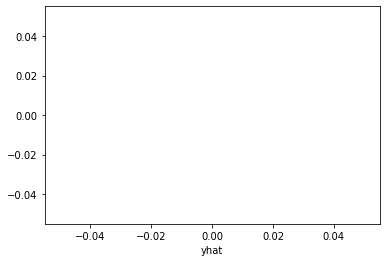

In [ ]:
fc_processed

1912    1.0
1913    1.0
1914    1.0
1915    0.0
1916    1.0
1917    1.0
1918    1.0
1919    1.0
1920    0.0
1921    1.0
1922    1.0
1923    0.0
1924    1.0
1925    1.0
1926    0.0
1927    1.0
1928    1.0
1929    0.0
1930    1.0
1931    0.0
1932    1.0
1933    1.0
1934    0.0
1935    1.0
1936    1.0
1937    0.0
1938    1.0
1939    0.0
Name: yhat, dtype: float64

KeyError: ignored

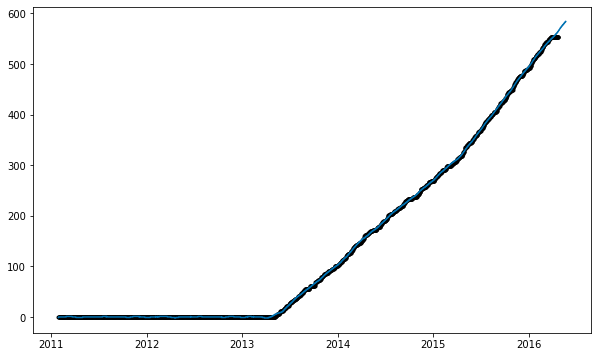

In [ ]:
# Plot
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [ ]:
#df_cv = cross_validation(m, initial='730 days', period='28 days', horizon = '84 days')
#pm = performance_metrics(df_cv, rolling_window=0.1)
#display(pm.head(),pm.tail())
#fig = plot_cross_validation_metric(df_cv, metric='mape', rolling_window=0.1)
#plt.show()

,id,FOODS_3_001_TX_3_validation,FOODS_3_002_TX_3_validation,FOODS_3_003_TX_3_validation,FOODS_3_004_TX_3_validation,FOODS_3_005_TX_3_validation,FOODS_3_006_TX_3_validation,FOODS_3_007_TX_3_validation,FOODS_3_008_TX_3_validation,FOODS_3_009_TX_3_validation,...,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA
0,d_1,0,0,0,0,0,0,27,0,0,...,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0
1,d_2,2,0,0,0,1,0,27,0,0,...,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0
2,d_3,1,0,0,0,1,0,8,0,0,...,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0
3,d_4,3,0,0,0,0,0,0,0,0,...,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1
4,d_5,0,0,0,0,0,0,0,0,0,...,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,d_1909,0,0,0,0,0,0,0,0,1,...,Wednesday,5,4,2016,d_1909,NaN,NaN,NaN,NaN,0
1909,d_1910,0,0,0,0,1,1,0,0,0,...,Thursday,6,4,2016,d_1910,NaN,NaN,NaN,NaN,0
1910,d_1911,5,0,1,0,0,1,0,0,0,...,Friday,7,4,2016,d_1911,NaN,NaN,NaN,NaN,0
1911,d_1912,2,0,0,0,4,1,0,0,0,...,Saturday,1,4,2016,d_1912,NaN,NaN,NaN,NaN,0


In [ ]:
# Prices With Calendar merge
# prices = pd.merge(prices, calendar, left_on='wm_yr_wk', right_on='wm_yr_wk')
# prices.to_csv("prices.csv")

In [ ]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
playoffs

In [ ]:
# Export train set to R
train_to_r = train.set_index('date', drop=False)
train_to_r = train_to_r.drop(columns=calendar.columns)
train_to_r.to_csv("train.csv")

In [ ]:
# Products on Saturday
prod1 = train.loc[train["weekday"] == "Saturday"]
prod1.to_csv("saturday.csv")

In [ ]:
test = test.merge(calendar, left_on="id", right_on="d")
test_to_r = test.set_index('date', drop=False)
test_to_r = test_to_r.drop(columns=calendar.columns)
test_to_r.to_csv("test.csv")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f10b2ef6-aec8-4f39-a467-0cb71d64e9c7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>